**<center> Joaquin Peñuela Parra, Cristian Fernando Rodriguez Cruz <center>**
**<center> University of Los Andes <center>**
**<center> High Energy Physics Group: Phenomenology of Particles <center>**

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import nbimporter

!git clone https://github.com/Phenomenology-group-uniandes/Heatmap_Utilities.git

sys.path.append(f'{os.getcwd()}/Heatmap_Utilities')
from Heatmap_Utilities.Main_Functions import smooth, plot_heatmap

Cloning into 'Heatmap_Utilities'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 62 (delta 28), reused 36 (delta 13), pack-reused 0
Receiving objects: 100% (62/62), 2.70 MiB | 3.94 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
path_statistical_preparation = os.path.join(os.path.dirname(os.getcwd()), '06_Statistical_Preparation')

In [3]:
def approx_global_sig(sig: np.array, bkg: np.array, N: float = 0.0) -> float:
    """
    Calculates the statistical significance of a signal over background in a given dataset using a modified version of
    the formula (S -N sqrt(B))/sqrt(S+B), where S is the number of signal events, B is the number of background events,
    and N is the expected number of background events in the signal region.

    Parameters:
    sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
    bkg (np.array): 1D array containing the number of background events in each bin of the dataset.
    N (float): Expected number of background events in the signal region. Default value is 0.0.

    Returns:
    float: The statistical significance of the signal over background in the dataset.
    """

    # calculate weight factor w for each bin
    w = np.log(1. + sig/(bkg + 1e-9))

    # calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w ** 2
    b_ww = bkg * w ** 2

    # calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww))

    # calculate statistical significance and return it
    return num / den

In [4]:
channels = ["hadronic_Tau_Tau", "hadronic_Tau_Tau_b", "hadronic_Tau_Tau_b_b", "semileptonic_Tau_Tau", "semileptonic_Tau_Tau_b", "semileptonic_Tau_Tau_b_b"]
Masses = ["1000", '1250', '1500', '1750', '2000', '2250', '2500']
signals = ['Lq_Lq', 'tau_Lq', 'tau_tau']
bkgs =  ['tbart', 'V+jets', 'stop', 'Diboson']
betards = ['woRHC', 'wRHC']

CMS_Scale_Factor = {'Lq_Lq': 4, 'tau_Lq': 2, 'tau_tau': 1}

In [5]:
Significances = {}

In [6]:
#sLQ, dLQ, non-res:

for betard in betards:
    Significances[betard] = {}
    folder_txt_files = f'{path_statistical_preparation}/txt_files_{betard}'

    for signal in signals:

        KFactors_Matrix = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/{signal}.xlsx', index_col= 0)
        KFactors_Matrix.columns = [float(column) for column in KFactors_Matrix.columns]
        KFactors_Matrix.index = [float(idx) for idx in KFactors_Matrix.index]

        Significances[betard][signal] = {}
        for Mass in Masses:

            Significances[betard][signal][float(Mass)] = {} 

            Signal_Data_1_8 = np.loadtxt(os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{signal}.txt"))

            BKG_Data = np.zeros(66)
            for bkg in bkgs:
                path_to_txt = os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{bkg}.txt")
                BKG_Data += np.loadtxt(path_to_txt)                

            for coupling in KFactors_Matrix.index:
                Signal_Data = Signal_Data_1_8*KFactors_Matrix[float(Mass)][coupling]
                Significances[betard][signal][float(Mass)][coupling] = approx_global_sig(Signal_Data*CMS_Scale_Factor[signal], BKG_Data)

In [7]:
#Combined:

for betard in betards:
    
    KFactors_Matrix_lq_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/Lq_Lq.xlsx', index_col= 0)
    KFactors_Matrix_lq_lq.columns = [float(column) for column in KFactors_Matrix_lq_lq.columns]
    KFactors_Matrix_lq_lq.index = [float(idx) for idx in KFactors_Matrix_lq_lq.index]
    
    KFactors_Matrix_tau_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/tau_Lq.xlsx', index_col= 0)
    KFactors_Matrix_tau_lq.columns = [float(column) for column in KFactors_Matrix_tau_lq.columns]
    KFactors_Matrix_tau_lq.index = [float(idx) for idx in KFactors_Matrix_tau_lq.index]
    
    KFactors_Matrix_tau_tau = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/tau_tau.xlsx', index_col= 0)
    KFactors_Matrix_tau_tau.columns = [float(column) for column in KFactors_Matrix_tau_tau.columns]
    KFactors_Matrix_tau_tau.index = [float(idx) for idx in KFactors_Matrix_tau_tau.index]
    
    KFactors_Matrix = {"Lq_Lq": KFactors_Matrix_lq_lq*4, "tau_Lq": KFactors_Matrix_tau_lq*2, "tau_tau": KFactors_Matrix_tau_tau}
    
    Significances[betard]['Combined'] = {}
    for Mass in Masses:

        Significances[betard]['Combined'][float(Mass)] = {} 

        for coupling in KFactors_Matrix["Lq_Lq"].index:
            Matrix_Signal = np.zeros([11,6])
            Matrix_BKG = np.zeros([11,6])
            for n, channel in enumerate(channels):
                for signal in signals:            
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{signal}.txt")
                    Matrix_Signal[:, n] +=  np.loadtxt(path_to_txt)*KFactors_Matrix[signal][int(Mass)][coupling]

                for bkg in bkgs:
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{bkg}.txt")
                    Matrix_BKG[:, n] += np.loadtxt(path_to_txt)                


            Signal_Data = np.asarray(Matrix_Signal.reshape((1,66)))
            BKG_Data = np.asarray(Matrix_BKG.reshape((1,66)))    
            Significances[betard]['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)


In [8]:
# #Combined:
# for betard in betards:
#     Significances[betard]['Combined'] = {}
    
#     for Mass in Masses:
#         Significances[betard]['Combined'][float(Mass)] = {} 
        
#         for coupling in KFactors_Matrix.index:              
#             Significances[betard]['Combined'][float(Mass)][coupling] = np.sqrt(sum(np.asarray([Significances[betard][signal][float(Mass)][coupling] for signal in signals])**2))

In [9]:
titulos_izquierda = {'Lq_Lq' : 'dLQ', 'tau_Lq' : 'sLQ', 'tau_tau' : 'non-res', 'Combined' : 'Combined'}

for betard in betards:
    for key in Significances[betard]:
        file_name = f'Significances/Significance_CMS_Comparison_Table_13TeV_L137_{titulos_izquierda[key]}_combined_{betard}.csv'.replace('Combined', 'all')
        pd.DataFrame.from_dict(Significances[betard][key]).to_csv(file_name)

In [10]:
expected = 'Expected_by_B_anomalies'
signals = ['Single', 'Pair', 'Total', 'Nonres']
linestyles = {'Continue': '-', 'Dashed': '--', 'Contour': ''}

Data_CMS = {}

Data_CMS[expected] = np.loadtxt(f'Data_CMS/Data_Right/{expected}.txt', delimiter = ';')
Data_CMS[expected][:,1] = Data_CMS[expected][:,1]*np.sqrt(2)
Data_CMS[expected][:,0] = Data_CMS[expected][:,0]/1000

for signal in signals:
    for linestyle in linestyles:
        Data_CMS[f'{signal}_{linestyle}'] = np.loadtxt(f'Data_CMS/Data_Right/{signal}_{linestyle}.txt', delimiter = ';')
        Data_CMS[f'{signal}_{linestyle}'][:,1] = Data_CMS[f'{signal}_{linestyle}'][:,1]*np.sqrt(2)
        Data_CMS[f'{signal}_{linestyle}'][:,0] = Data_CMS[f'{signal}_{linestyle}'][:,0]/1000

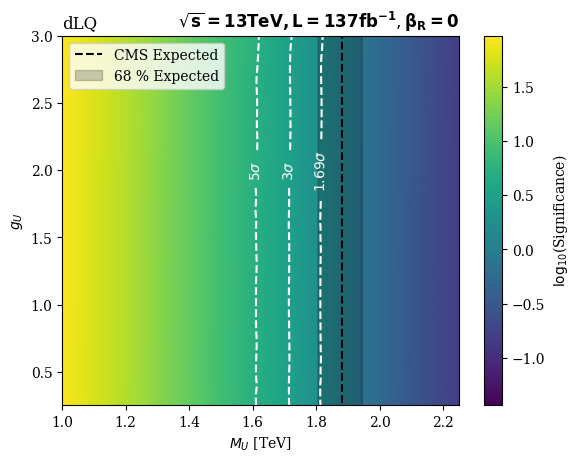

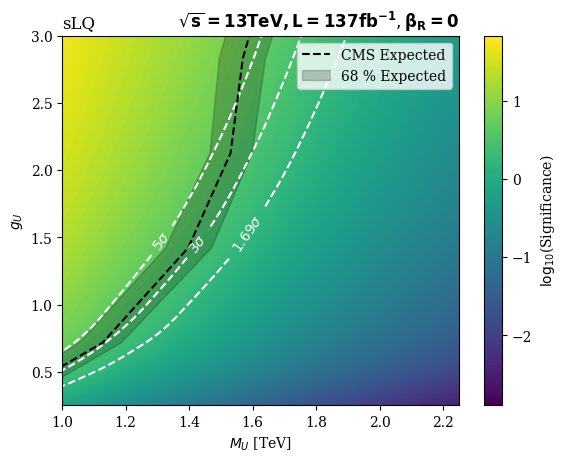

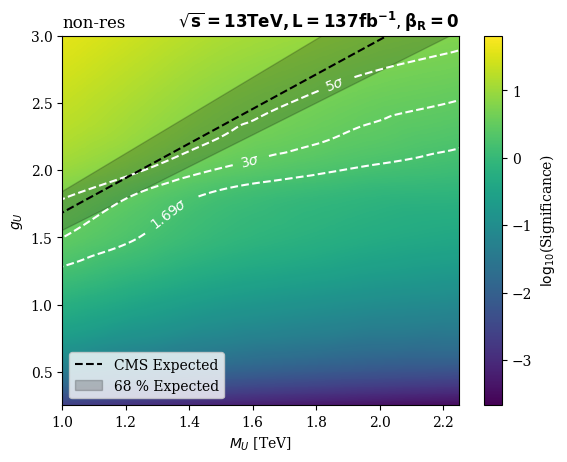

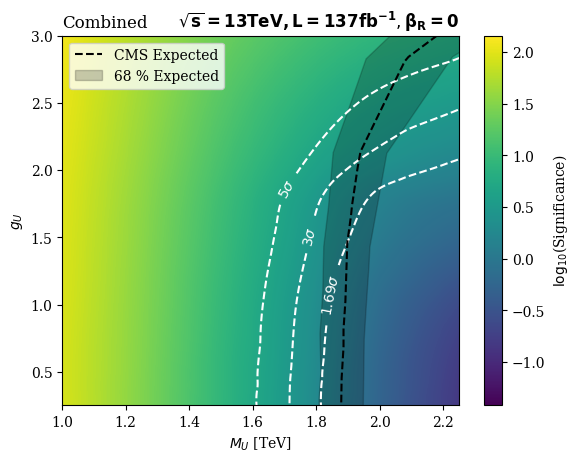

In [11]:
betards = ['woRHC']

titulos_izquierda = {'Lq_Lq' : 'dLQ', 'tau_Lq' : 'sLQ', 'tau_tau' : 'non-res', 'Combined' : 'Combined'}
betard_title = {'wRHC': r'$, \mathbf{\beta_{R} = -1}$', 'woRHC': r'$, \mathbf{\beta_{R} = 0}$'}

ubicaciones = {'Lq_Lq_woRHC': [[1600/1000,2], [1700/1000, 2], [1800/1000, 2]],
               'tau_Lq_woRHC': [[1300/1000,1.5], [1400/1000, 1.5], [1600/1000, 1.5]], 
               'tau_tau_woRHC': [[1400/1000,1.5], [1600/1000, 2.25], [1800/1000, 3]], 
               'Combined_woRHC':[[1600/1000,2], [1800/1000, 1.5], [2000/1000, 1]]
              }

ubicaciones = {'Lq_Lq_woRHC': [[1600/1000,2], [1700/1000, 2], [1800/1000, 2]],
               'tau_Lq_woRHC': [[1300/1000,1.5], [1400/1000, 1.5], [1600/1000, 1.5]], 
               'tau_tau_woRHC': [[1400/1000,1.5], [1600/1000, 2], [1800/1000, 3]], 
               'Combined_woRHC':[[1600/1000,2], [1800/1000, 1.5], [2000/1000, 1]]
              }

def Calcular_g_U(c_U, M):
    v = 246
    return 2*np.sqrt(c_U)*M/v

for betard in betards:
    for key in Significances[betard]:
        Data = pd.DataFrame.from_dict(Significances[betard][key])
        Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
        Data_interpolate = smooth(Data, log = True)
        
        fig, ax, curves = plot_heatmap(Data_interpolate,
                                       curvas_de_nivel = {np.log10(1.69) : r'$1.69 \sigma$', np.log10(3): r'$3 \sigma$', np.log10(5): r'$5 \sigma$'},
                                       curves_labels_locations= ubicaciones[f'{key}_{betard}'],
                                       titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$' + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
                                      )
        
#         if betard == 'wRHC': c_u1, c_u2 = 0.006, 0.002
#         else:  c_u1, c_u2 = 0.017, 0.007
            
#         x = np.linspace(1000/1000, 2250/1000, 1000)

#         x_1, y_1 = 1000/1000, Calcular_g_U(c_u1, 1000)
#         x_2, y_2 = 2250/1000, Calcular_g_U(c_u1, 2250)

#         y1 = np.poly1d(np.polyfit([x_1,x_2], [y_1, y_2], deg=1))(x)

#         x_3, y_3 = 1000/1000, Calcular_g_U(c_u2, 1000)
#         x_4, y_4 = 2250/1000, Calcular_g_U(c_u2, 2250)

#         y2 = np.poly1d(np.polyfit([x_3,x_4], [y_3, y_4], deg=1))(x)

#         ax.plot(x, y1, c='black', alpha=0.5)
#         ax.plot(x, y2, c='black', alpha=0.5)

#         x = np.concatenate((x[0], x, x[-1]), axis = None)
#         y = np.concatenate((y2[0], y1, y2[-1]), axis = None)
#         ax.fill(x, y, 'gray', alpha=0.15, label = 'B anomalies')    
                
        if ('sLQ' == titulos_izquierda[key]): 
            plt.plot(Data_CMS['Single_Dashed'][:,0], Data_CMS['Single_Dashed'][:,1], linestyle = '--', label = 'CMS Expected', color = 'black')
            ax.fill(Data_CMS['Single_Contour'][:,0], Data_CMS['Single_Contour'][:,1], label = '68 % Expected', color = 'black', alpha = 0.2)

        elif ('dLQ' == titulos_izquierda[key]): 
            plt.plot(Data_CMS['Pair_Dashed'][:,0], Data_CMS['Pair_Dashed'][:,1], linestyle = '--', label = 'CMS Expected', color = 'black')
            ax.fill(Data_CMS['Pair_Contour'][:,0], Data_CMS['Pair_Contour'][:,1], label = '68 % Expected', color = 'black', alpha = 0.2)

        elif ('non-res' == titulos_izquierda[key]): 
            plt.plot(Data_CMS['Nonres_Dashed'][:,0], Data_CMS['Nonres_Dashed'][:,1], linestyle = '--', label = 'CMS Expected', color = 'black')
            ax.fill(Data_CMS['Nonres_Contour'][:,0], Data_CMS['Nonres_Contour'][:,1], label = '68 % Expected', color = 'black', alpha = 0.2)

        else: #Combined 
            plt.plot(Data_CMS['Total_Dashed'][:,0], Data_CMS['Total_Dashed'][:,1], linestyle = '--', label = 'CMS Expected', color = 'black')
            ax.fill(Data_CMS['Total_Contour'][:,0], Data_CMS['Total_Contour'][:,1], label = '68 % Expected', color = 'black', alpha = 0.2)
            
        plt.xlim(1, 2.25)
        plt.ylim(0.25,3)            
        plt.legend(loc="best")         
        
        file_name = f'Significances/Significance_CMS_Comparison_13TeV_L137_{titulos_izquierda[key]}_combined_{betard}.png'.replace('Combined', 'all')
        plt.savefig(file_name, bbox_inches='tight')

In [12]:
%%capture

betards = ['woRHC', 'wRHC']
sigma_curves = {}
for betard in betards:
    sigma_curves[betard] = {}
    
    for key in Significances[betard]:
        Data = pd.DataFrame.from_dict(Significances[betard][key])
        Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
        Data_interpolate = smooth(Data, log = True)
        
        fig, ax, sigma_curves[betard][key] = plot_heatmap(Data_interpolate,
                                       curvas_de_nivel = {np.log10(1.69) : '', np.log10(3): '', np.log10(5): ''},
                                       titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$' + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
                                      )

In [13]:
#let's save sigma_curves in order to plot curves in other jupyter notebook:
sigma_curves

{'woRHC': {'Lq_Lq': <matplotlib.contour.QuadContourSet at 0x7ff08c47ce50>,
  'tau_Lq': <matplotlib.contour.QuadContourSet at 0x7ff08a2d6d40>,
  'tau_tau': <matplotlib.contour.QuadContourSet at 0x7ff08a378e50>,
  'Combined': <matplotlib.contour.QuadContourSet at 0x7ff0887aabc0>},
 'wRHC': {'Lq_Lq': <matplotlib.contour.QuadContourSet at 0x7ff0887e3520>,
  'tau_Lq': <matplotlib.contour.QuadContourSet at 0x7ff0880cedd0>,
  'tau_tau': <matplotlib.contour.QuadContourSet at 0x7ff081278b80>,
  'Combined': <matplotlib.contour.QuadContourSet at 0x7ff0812fae00>}}

In [14]:
file = open("Significances/sigma_curves_CMS_Comparison.pkl","wb")
pickle.dump(sigma_curves,file)
file.close()

In [15]:
!rm -rf Heatmap_Utilities/